<p style="background-color: white; color: black; font-family: Cambria; font-size: 2em; text-align: center; border-radius: 30px; box-shadow: 0 4px 8px lightsteelblue; padding: 25px;  border: 1px solid black;">
GAN implementation
<br>
</p>

<p style="background-color: white; color: black; font-family: Georgia; font-size: 2em; text-align: left; border-radius: 10px; padding: 10px; box-shadow: 0 4px 8px lightsteelblue; margin: 20px 0; margin-right: 70%; border: 1px solid black;">
0. Importing libraries
</p>

In [1]:
# Importing necessary libraries
import os
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from generate_data import helpers, get_config
import data.sportballs as sb
import argparse
%matplotlib inline

Checking the availability of CUDA to train our models:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<p style="background-color: white; color: black; font-family: Georgia; font-size: 2em; text-align: left; border-radius: 10px; padding: 10px; box-shadow: 0 4px 8px lightsteelblue; margin: 20px 0; margin-right: 70%; border: 1px solid black;">
1. Prepearing the data
</p>

### Generating the "real" dataset to train the model

Let's generate 10 000 images from imported function with cusomized config file.  
We will use these images to compare with generated images and train Discriminator and Generator:

In [3]:
# Asigning the config path
cfile = "config.ini"

# And load it
config = get_config(cfile)

# Generate the sportballs dataset
sb.store_sports_balls(
    length=config.length,
    train=config.train,
    path=config.path,
    canvas_size=config.c_size,
    object_size=config.o_size,
    n_objects=config.n_objects,
    random_cls=config.task4
)

Folder data/SportBallsSmall/Test created.
Will generate 10000 images into data/SportBallsSmall/Test.
0 images done and 10000 still to do.
500 images done and 9500 still to do.
1000 images done and 9000 still to do.
1500 images done and 8500 still to do.
2000 images done and 8000 still to do.
2500 images done and 7500 still to do.
3000 images done and 7000 still to do.
3500 images done and 6500 still to do.
4000 images done and 6000 still to do.
4500 images done and 5500 still to do.
5000 images done and 5000 still to do.
5500 images done and 4500 still to do.
6000 images done and 4000 still to do.
6500 images done and 3500 still to do.
7000 images done and 3000 still to do.
7500 images done and 2500 still to do.
8000 images done and 2000 still to do.
8500 images done and 1500 still to do.
9000 images done and 1000 still to do.
9500 images done and 500 still to do.


Now we load all the images using Pytorch Dataloader:

In [3]:
path = 'data/SportBallsSmall/Test'

# Loading images to the list: converting to RGB each file with .png file type
train_images = [Image.open(os.path.join(path, file)).convert('RGB') for file in os.listdir(path) if file.endswith('png')]
print(train_images[0])

<PIL.Image.Image image mode=RGB size=32x32 at 0x7DEAD45A6290>


And to transform our images to further training:

In [4]:
# First, we create the function to apply transformations
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Making a list of transformed images
transformed_images = list(transform(img) for img in train_images)

# And converting them to tensor
transformed_images = torch.stack(transformed_images)
transformed_images[0]

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

Our images have **3 channels** - RGB, and shape of 32x32 pixels:

In [5]:
transformed_images[0].shape

torch.Size([3, 32, 32])

Let's look at our images:

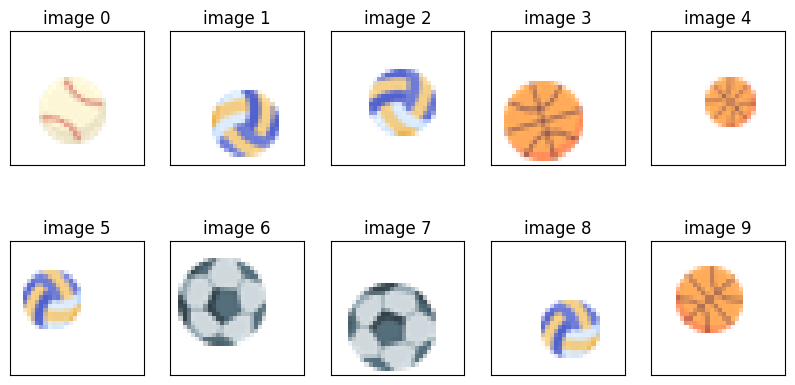

In [7]:
fix, ax = plt.subplots(2, 5, figsize=(10,5))

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(train_images[i*5+j])
        ax[i,j].set_title(f'image {i*5+j}')
        ax[i,j].xaxis.set_visible(False)
        ax[i,j].yaxis.set_visible(False)
plt.show()

<p style="background-color: white; color: black; font-family: Georgia; font-size: 2em; text-align: left; border-radius: 10px; padding: 10px; box-shadow: 0 4px 8px lightsteelblue; margin: 20px 0; margin-right: 67%; border: 1px solid black;">
2. GAN Models design
</p>

### General idea:

We have two neural networks - one generates images - **Generator**, and another classifies if the image is *real* or *fake* - **Discriminator**.  
The first network should generate such images, so the second one would think that this image is real.
The second one should distinguish real from fake.

Since we want to predict either image is real of fake. or, 1 or 0, in this taks **binary cross-entropy** is the best choice to use as a loss function:
$$\text{BCE Loss} = -\frac{1}{N}\sum_{i=0}^{N} y_i \cdot log(\hat{y_i}) + (1-y_i) \cdot log(1 - \hat{y_i}))$$

We want the generated (green) data to be as close as possible to the black (real) data:

<img src="./GAN.png" width="800" height="600" style="float: left;">

Photo - [Ian Goodfellow paper](https://arxiv.org/pdf/1406.2661)

### To train our model we will provide three steps:
1. Train discriminator:
   - Pass real image to discriminator, get the "real image" probability
         $$Loss_{Real} = - y_{real} \cdot \log(prob(y = 1)) - (1 - y_{real}) \cdot \log(1 - prob(y = 1))$$
   - Pass fake image to discriminator, get the "fake image" probability
         $$Loss_{Fake} = - y_{fake} \cdot \log(prob(y = 0)) - (1 - y_{fake}) \cdot \log(1 - prob(y = 0))$$
   - Calculate the loss for discriminator using these values. Since the values that we want to achieve are: $y_{real}$ = 1 and $y_{fake}$ = 0, we want to minimize the loss:
         $$Loss_{D} = Loss_{Real} + Loss_{Fake}$$
         $$Loss_{D} = - 1 \cdot \log(prob(y = 1)) - 1 \cdot \log(1 - prob(y = 0))$$
         $$Loss_{D} = - \log(prob(y = 1)) - \log(1 - prob(y = 0))$$
2. Train generator:
   - Generate fake image from Gaussian noise: $\mu$ = 0, $\sigma$ = 1
   - Pass generated image to discriminator, get the "fake image" probability
         $$Loss_{Gen} = - y_{fake} \cdot \log(prob(y = 0)) - (1 - y_{fake}) \cdot \log(1 - prob(y = 0))$$
   - Calculate the loss for generator. Now we want to achieve $y_{fake}$ = 1 and $y_{real}$ = 0 to fool the discriminator. So, we want to maximize this:
         $$Loss_{Gen} = - \log(prob(y = 0))$$
4. Repeat steps 1 and 2 one by one $n$ times


## v.1. Implementation

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.linear_1 = nn.Linear(latent_dim, 1024 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(512)
        self.batchnorm_2 = nn.BatchNorm2d(256)
        self.batchnorm_3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.linear_1(x)
        x = x.view(-1, 1024, 8, 8)  # Reshape to 8x8 images with 1024 channels
        x = F.relu(self.batchnorm_1(self.conv1(x)))  # Transpose conv to 16x16
        x = F.relu(self.batchnorm_2(self.conv2(x)))  # Transpose conv to 32x32
        x = F.relu(self.batchnorm_3(self.conv3(x)))  # Conv layer to refine
        x = torch.tanh(self.conv4(x))  # Conv layer to get final 3 channel image
        return x


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)   # Output: (64, 16, 16)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False) # Output: (128, 8, 8)
        self.batchnorm_2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)# Output: (256, 4, 4)
        self.batchnorm_3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)# Output: (512, 2, 2)
        self.batchnorm_4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 2, stride=1, padding=0, bias=False) # Output: (1, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        x = F.leaky_relu(self.batchnorm_2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batchnorm_3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batchnorm_4(self.conv4(x)), 0.2, inplace=True)
        x = self.sigmoid(self.conv5(x))
        return x.view(-1, 1)

Functions to denormalize and print images that are created by Generator:

In [12]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=img.dtype, device=img.device)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=img.dtype, device=img.device)
    img = img * std[None, :, None, None] + mean[None, :, None, None]
    return img

def print_generated_images(epoch, batch, images):
    images = denormalize(images)
    images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

During the training process for both Generator and Discriminator we use backpropogation.  
Training function:

In [43]:
def train(generator, discriminator, train_loader, epochs, latent_dim, learning_rate, loss):

    # Lists to store losses
    g_losses = []
    d_losses = []

    # Training loop
    for epoch in range(epochs):
        for i, imgs in enumerate(train_loader):

            # Ground truths for batch, for real - 1s, for fake - 0s
            valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
            fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

            # Getting real images
            real_imgs = imgs.to(device)
            optimizer_G.zero_grad()

            # Sample random vector of normal distribution with mu=0, sigma=1
            z = torch.randn(imgs.size(0), latent_dim).to(device)

            # Generate fake images
            gen_imgs = generator(z)

            # Generator losses
            g_loss = loss(discriminator(gen_imgs), valid)

            # Backpropogation
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()

            # Discriminator losses for real and fake images
            real_loss = loss(discriminator(real_imgs), valid)
            fake_loss = loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            # Backpropogation
            d_loss.backward()
            optimizer_D.step()

            # Store losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            # Print progress and save generated images
            if i % 313 == 0:
                print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(train_loader)} "
                    f"Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

                # Save and show generated images
                print_generated_images(epoch, i, gen_imgs[:10])

    return g_losses, d_losses, generator, discriminator

Fine-tuning the model:

In [236]:
# Hyperparameters
latent_dim = 256
epochs = 150

# Initialize models
generator = Generator(latent_dim)
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)

# Loss function and optimizers
loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))


# Prepearing data with batches
batch_size = 32
train_loader = DataLoader(transformed_images, batch_size=batch_size, shuffle=True)


Epoch [0/150] Batch 0/313 Loss D: 0.6472342610359192, loss G: 0.7223807573318481


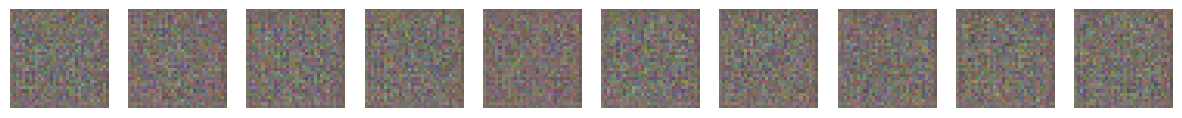

Epoch [1/150] Batch 0/313 Loss D: 0.3982285261154175, loss G: 1.031921148300171


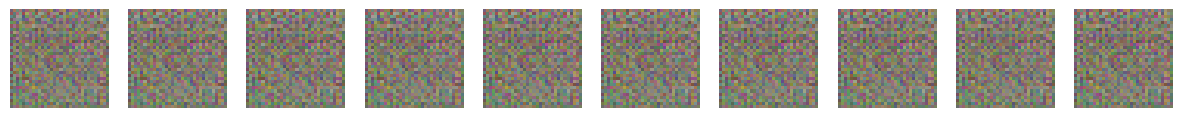

Epoch [2/150] Batch 0/313 Loss D: 0.6119893789291382, loss G: 0.7128069400787354


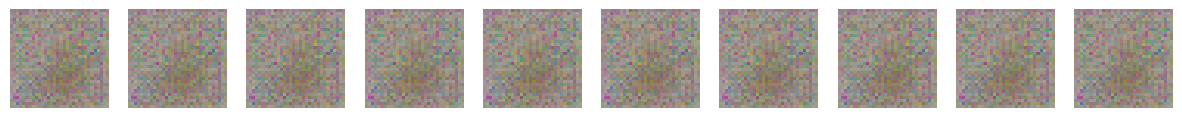

Epoch [3/150] Batch 0/313 Loss D: 0.8256970643997192, loss G: 0.5483862161636353


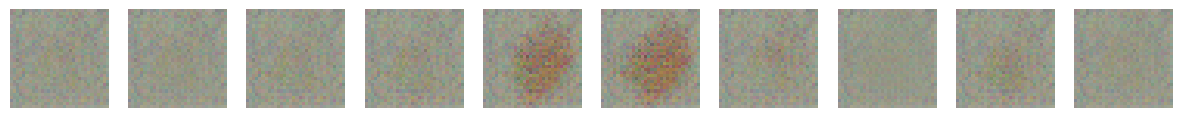

Epoch [4/150] Batch 0/313 Loss D: 0.770294189453125, loss G: 0.6285737752914429


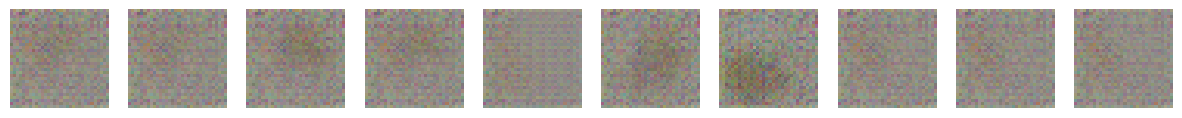

Epoch [5/150] Batch 0/313 Loss D: 0.7263225317001343, loss G: 0.695425271987915


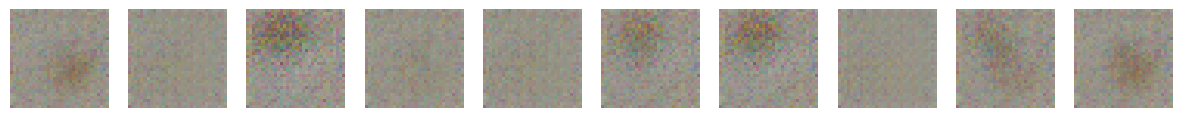

Epoch [6/150] Batch 0/313 Loss D: 0.7296165823936462, loss G: 0.6759742498397827


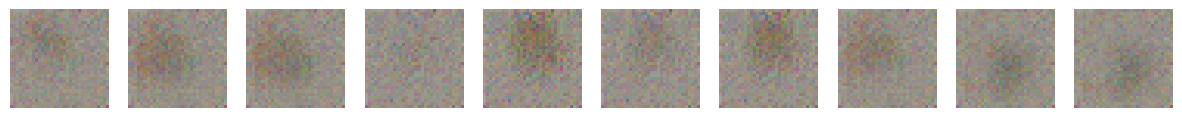

Epoch [7/150] Batch 0/313 Loss D: 0.708946704864502, loss G: 0.6822245121002197


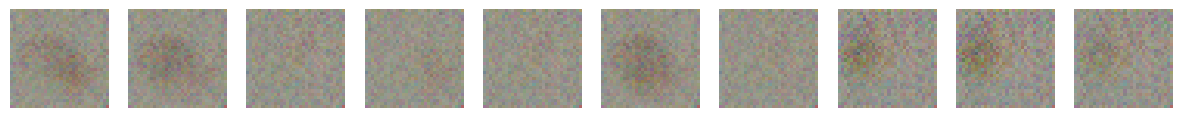

Epoch [8/150] Batch 0/313 Loss D: 0.6990295648574829, loss G: 0.7063309550285339


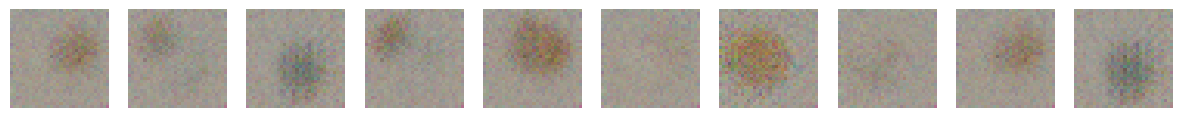

Epoch [9/150] Batch 0/313 Loss D: 0.7102437019348145, loss G: 0.6770938038825989


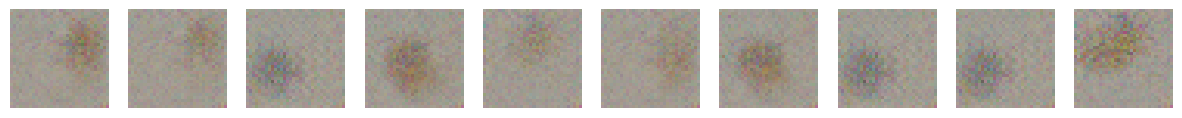

Epoch [10/150] Batch 0/313 Loss D: 0.7028906345367432, loss G: 0.6895895004272461


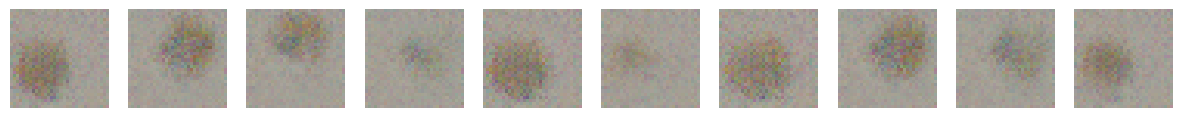

Epoch [11/150] Batch 0/313 Loss D: 0.6642508506774902, loss G: 0.7221027612686157


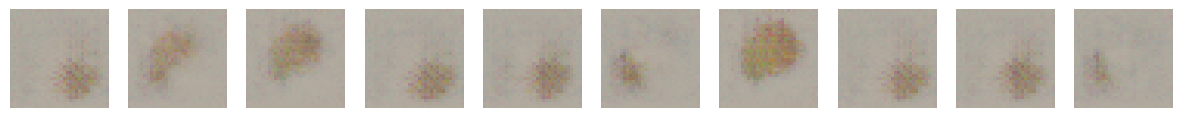

Epoch [12/150] Batch 0/313 Loss D: 0.6925804615020752, loss G: 0.6932392120361328


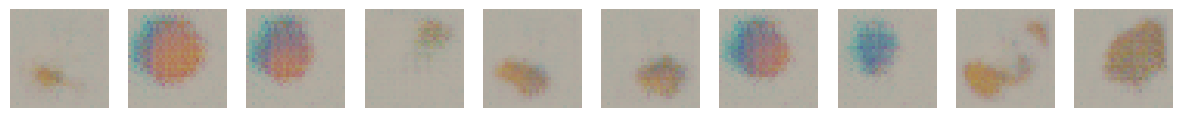

Epoch [13/150] Batch 0/313 Loss D: 0.6958793997764587, loss G: 0.6810019016265869


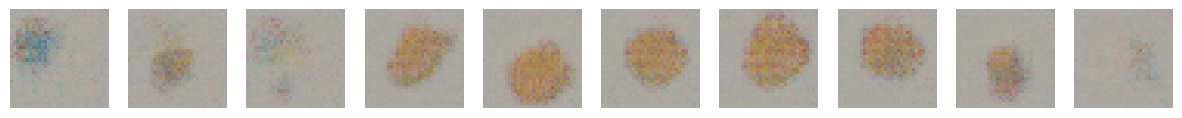

Epoch [14/150] Batch 0/313 Loss D: 0.7011895179748535, loss G: 0.6799607276916504


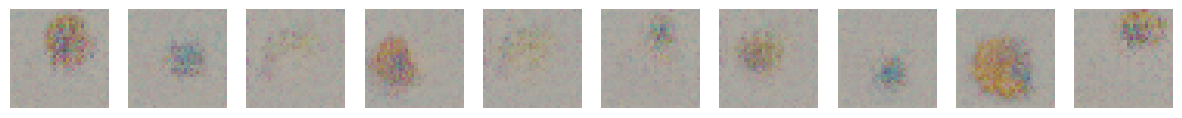

Epoch [15/150] Batch 0/313 Loss D: 0.7000519037246704, loss G: 0.6850947141647339


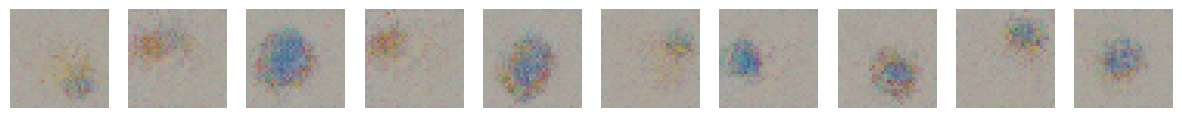

Epoch [16/150] Batch 0/313 Loss D: 0.7028666734695435, loss G: 0.6841837763786316


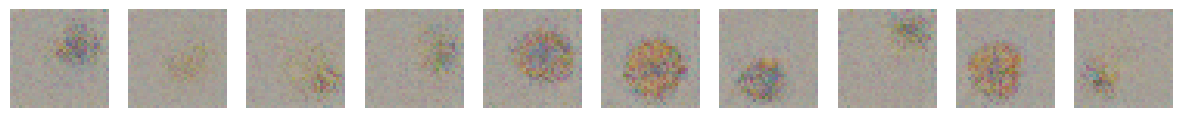

Epoch [17/150] Batch 0/313 Loss D: 0.7008758783340454, loss G: 0.6815558671951294


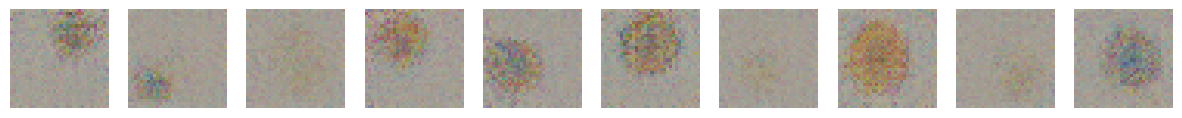

Epoch [18/150] Batch 0/313 Loss D: 0.7064105272293091, loss G: 0.6766307353973389


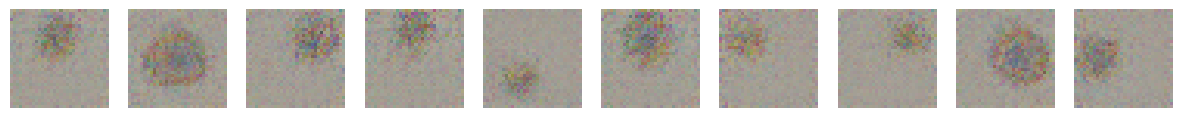

Epoch [19/150] Batch 0/313 Loss D: 0.7033265829086304, loss G: 0.6847661733627319


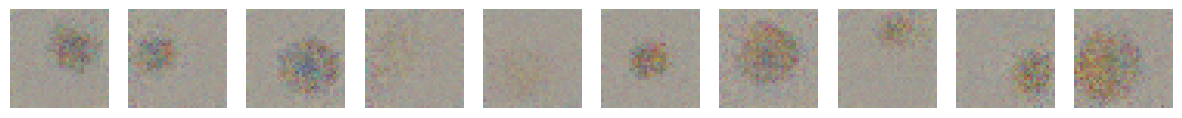

Epoch [20/150] Batch 0/313 Loss D: 0.7066770195960999, loss G: 0.6880571842193604


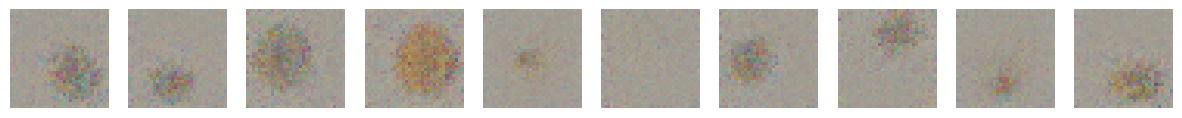

Epoch [21/150] Batch 0/313 Loss D: 0.7000513076782227, loss G: 0.686664342880249


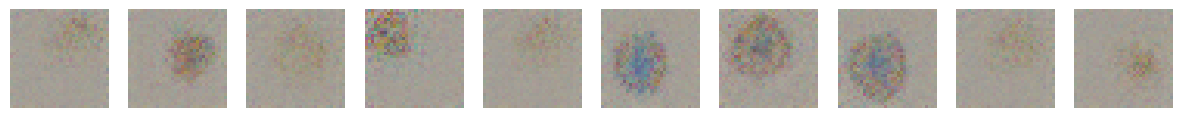

Epoch [22/150] Batch 0/313 Loss D: 0.6981714963912964, loss G: 0.6878571510314941


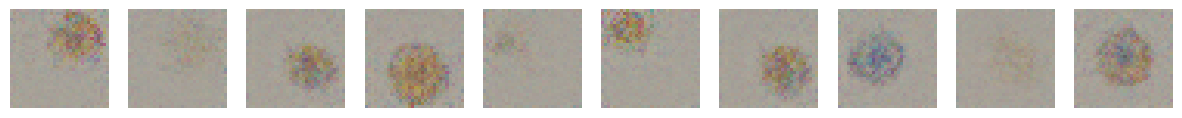

Epoch [23/150] Batch 0/313 Loss D: 0.6923629641532898, loss G: 0.6949234008789062


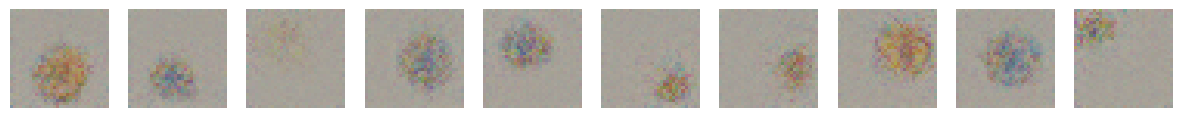

Epoch [24/150] Batch 0/313 Loss D: 0.7024334073066711, loss G: 0.6765915155410767


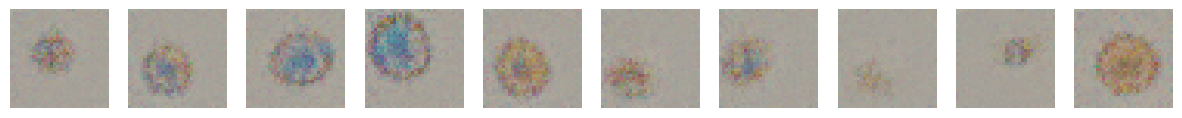

Epoch [25/150] Batch 0/313 Loss D: 0.6974482536315918, loss G: 0.6871364116668701


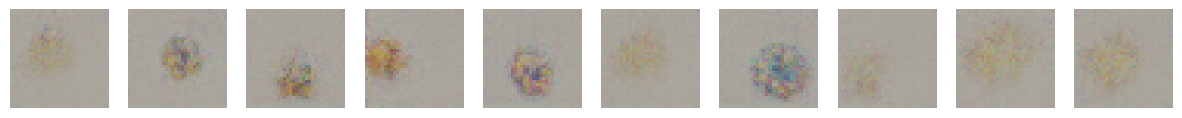

Epoch [26/150] Batch 0/313 Loss D: 0.7004835605621338, loss G: 0.6869113445281982


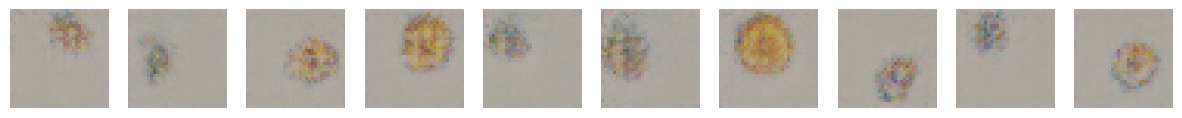

Epoch [27/150] Batch 0/313 Loss D: 0.6933878660202026, loss G: 0.6852468252182007


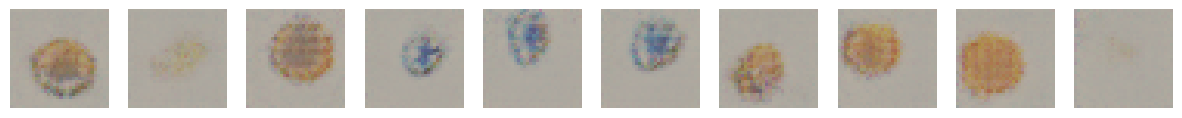

Epoch [28/150] Batch 0/313 Loss D: 0.6922489404678345, loss G: 0.6915988326072693


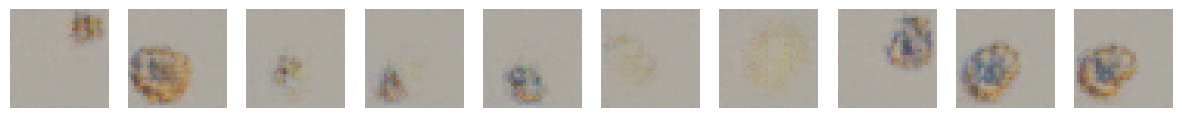

Epoch [29/150] Batch 0/313 Loss D: 0.6930999755859375, loss G: 0.6904522180557251


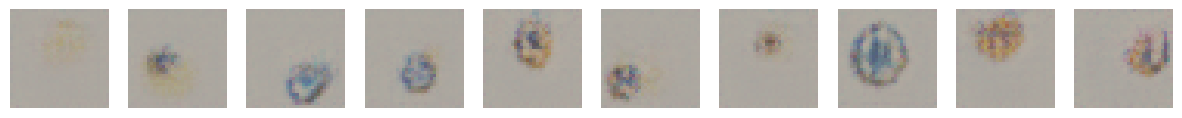

Epoch [30/150] Batch 0/313 Loss D: 0.6963670253753662, loss G: 0.7015408873558044


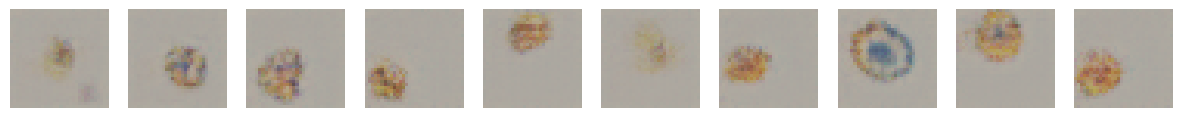

Epoch [31/150] Batch 0/313 Loss D: 0.6989715099334717, loss G: 0.6863398551940918


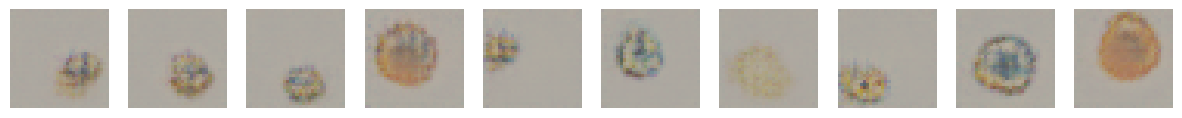

Epoch [32/150] Batch 0/313 Loss D: 0.699127733707428, loss G: 0.6890884637832642


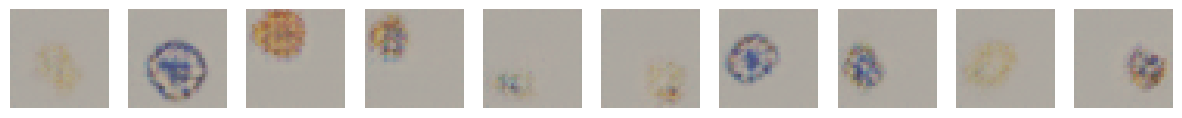

Epoch [33/150] Batch 0/313 Loss D: 0.6912122964859009, loss G: 0.6903523206710815


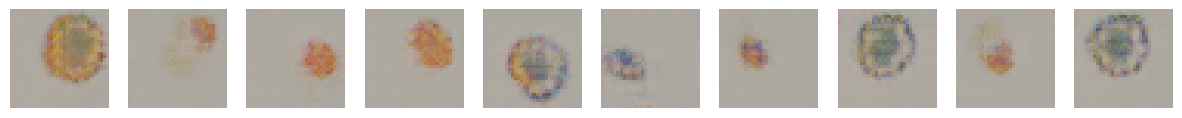

Epoch [34/150] Batch 0/313 Loss D: 0.6955752968788147, loss G: 0.6904738545417786


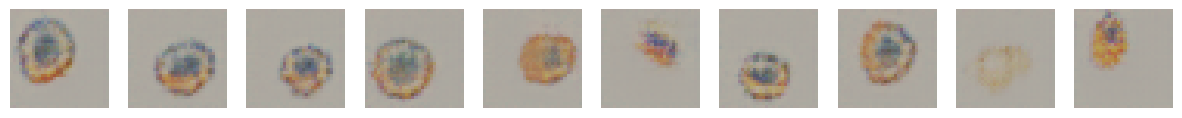

Epoch [35/150] Batch 0/313 Loss D: 0.6967386603355408, loss G: 0.6930917501449585


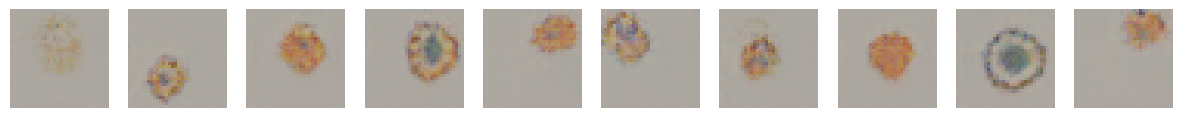

Epoch [36/150] Batch 0/313 Loss D: 0.6911929249763489, loss G: 0.689862847328186


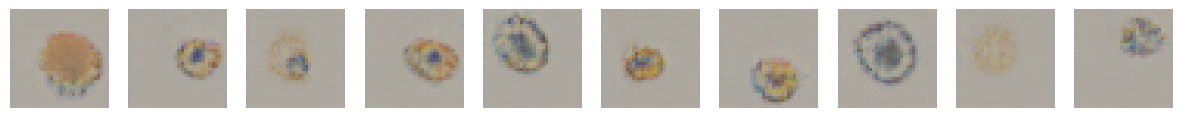

Epoch [37/150] Batch 0/313 Loss D: 0.6937172412872314, loss G: 0.6843501925468445


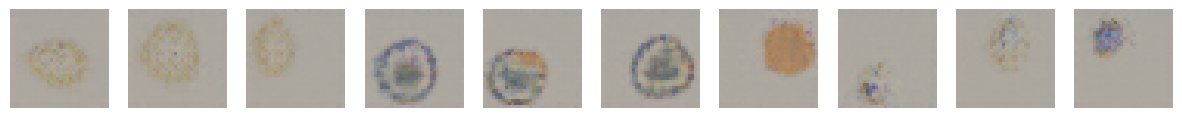

Epoch [38/150] Batch 0/313 Loss D: 0.6944893598556519, loss G: 0.6953586339950562


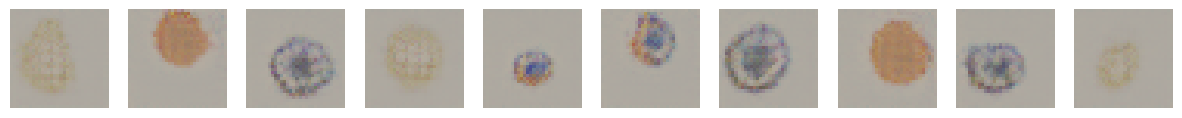

Epoch [39/150] Batch 0/313 Loss D: 0.7003207206726074, loss G: 0.6846174001693726


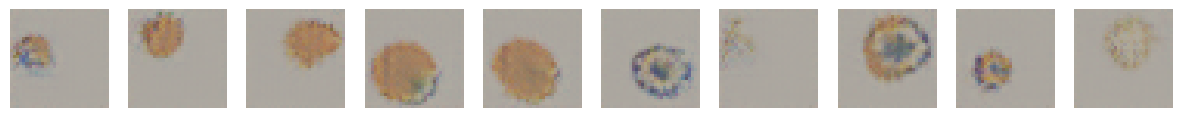

Epoch [40/150] Batch 0/313 Loss D: 0.6990870237350464, loss G: 0.6844690442085266


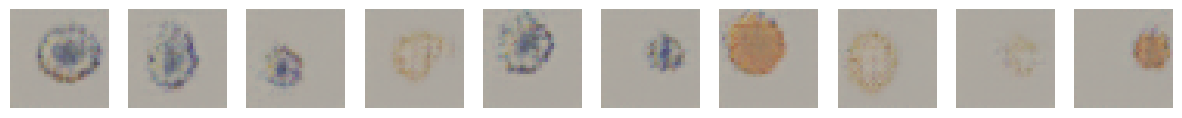

Epoch [41/150] Batch 0/313 Loss D: 0.7009071707725525, loss G: 0.6861143708229065


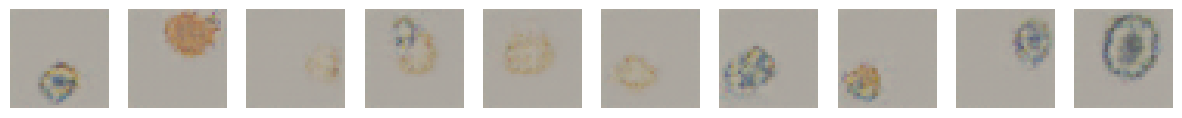

Epoch [42/150] Batch 0/313 Loss D: 0.6883280277252197, loss G: 0.6969456672668457


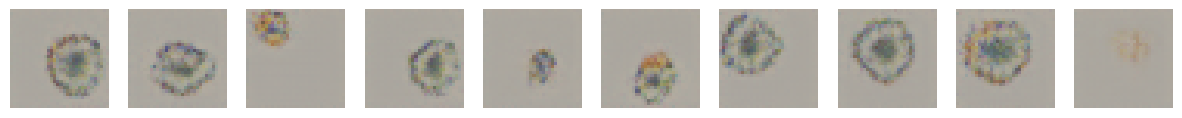

Epoch [43/150] Batch 0/313 Loss D: 0.6921442151069641, loss G: 0.6907492876052856


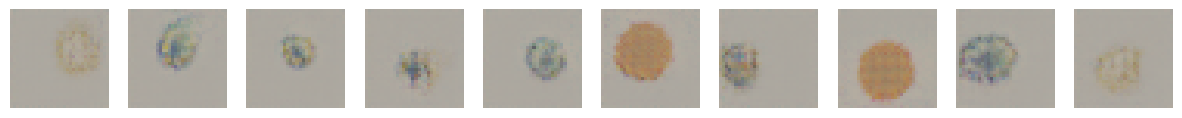

Epoch [44/150] Batch 0/313 Loss D: 0.6865049600601196, loss G: 0.6984153985977173


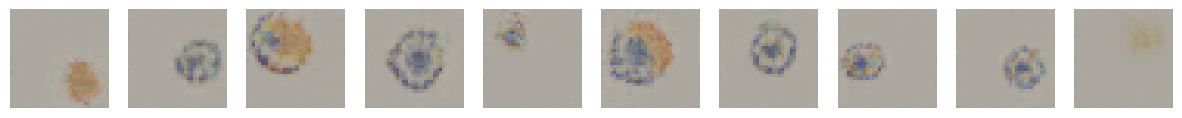

Epoch [45/150] Batch 0/313 Loss D: 0.6919765472412109, loss G: 0.7116432189941406


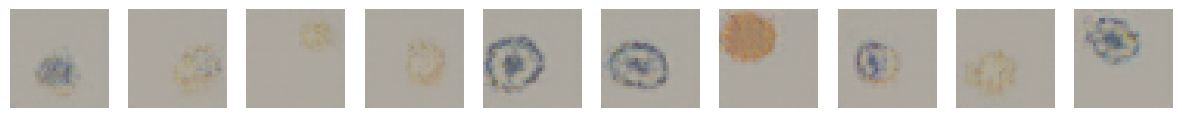

Epoch [46/150] Batch 0/313 Loss D: 0.6869902014732361, loss G: 0.6922675371170044


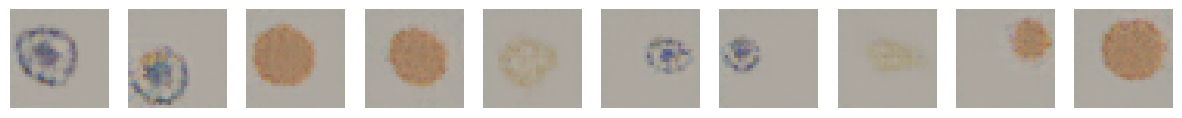

Epoch [47/150] Batch 0/313 Loss D: 0.6936995387077332, loss G: 0.6905896067619324


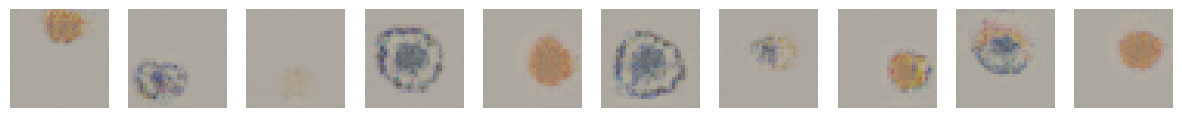

Epoch [48/150] Batch 0/313 Loss D: 0.6926169991493225, loss G: 0.6910779476165771


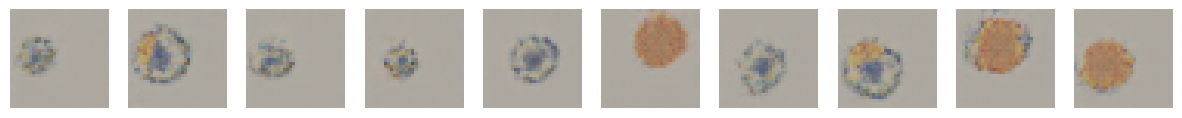

Epoch [49/150] Batch 0/313 Loss D: 0.6930779218673706, loss G: 0.6991305351257324


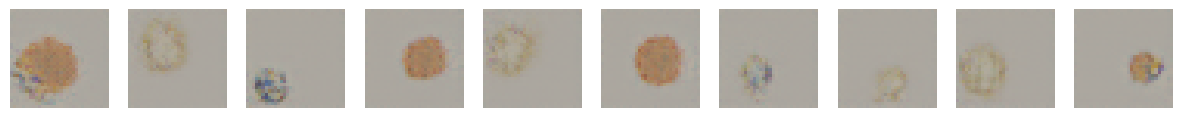

Epoch [50/150] Batch 0/313 Loss D: 0.6972708106040955, loss G: 0.6885506510734558


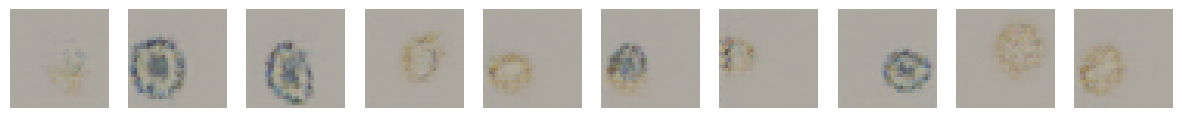

Epoch [51/150] Batch 0/313 Loss D: 0.6904563307762146, loss G: 0.6906403303146362


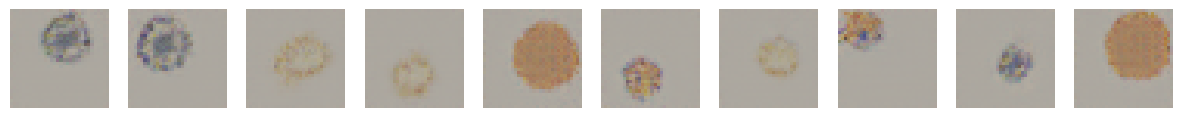

Epoch [52/150] Batch 0/313 Loss D: 0.6912450790405273, loss G: 0.7019137144088745


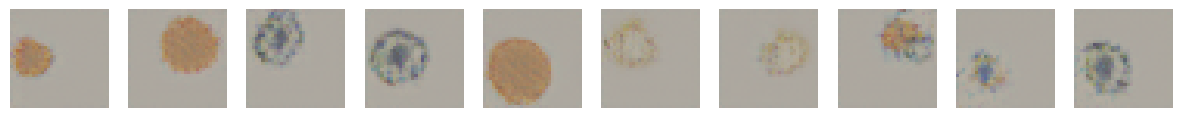

Epoch [53/150] Batch 0/313 Loss D: 0.6924803256988525, loss G: 0.6853842735290527


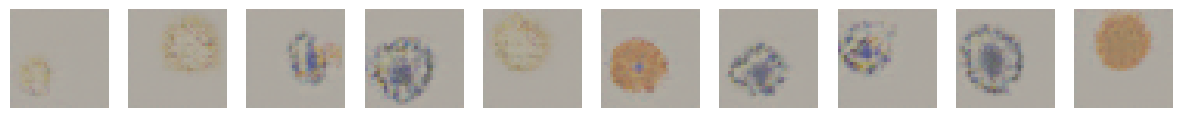

Epoch [54/150] Batch 0/313 Loss D: 0.6916425824165344, loss G: 0.6994537115097046


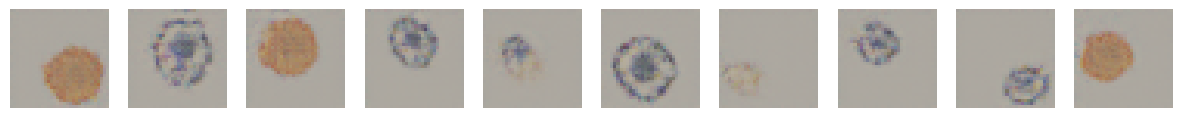

Epoch [55/150] Batch 0/313 Loss D: 0.6945950388908386, loss G: 0.6855170130729675


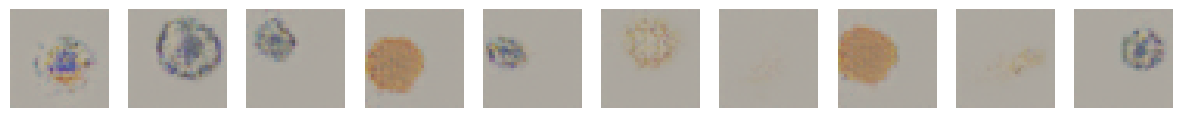

Epoch [56/150] Batch 0/313 Loss D: 0.7004547715187073, loss G: 0.69532710313797


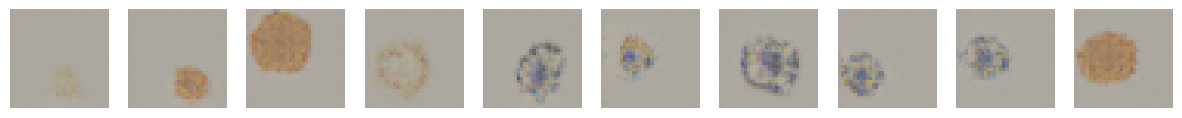

Epoch [57/150] Batch 0/313 Loss D: 0.6942769289016724, loss G: 0.6882759928703308


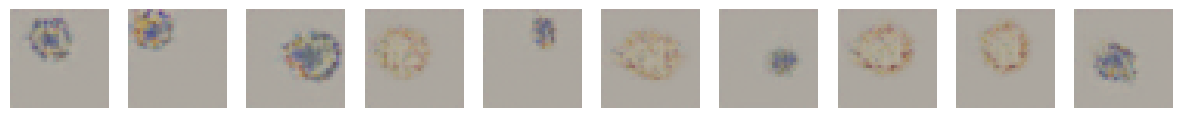

Epoch [58/150] Batch 0/313 Loss D: 0.691516637802124, loss G: 0.69687420129776


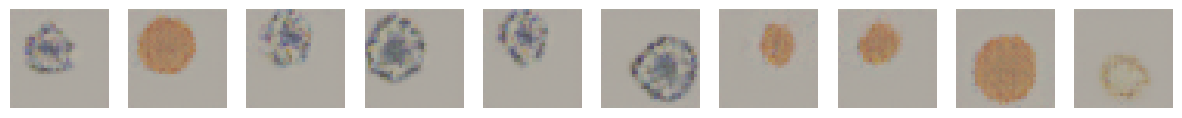

Epoch [59/150] Batch 0/313 Loss D: 0.6839316487312317, loss G: 0.7139975428581238


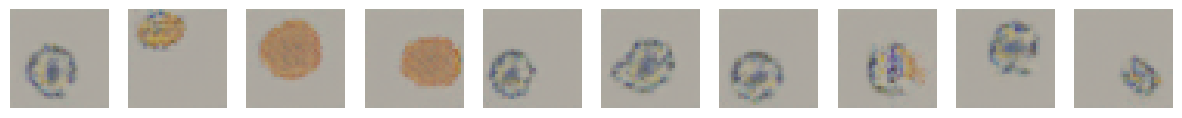

Epoch [60/150] Batch 0/313 Loss D: 0.6935024857521057, loss G: 0.7109566926956177


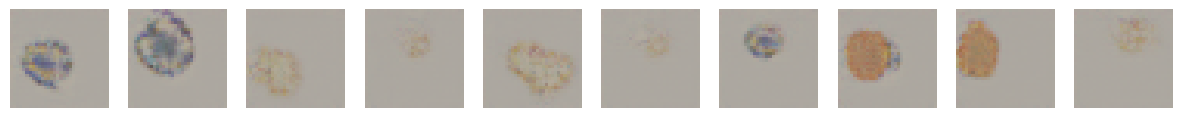

Epoch [61/150] Batch 0/313 Loss D: 0.6757628917694092, loss G: 0.7142091989517212


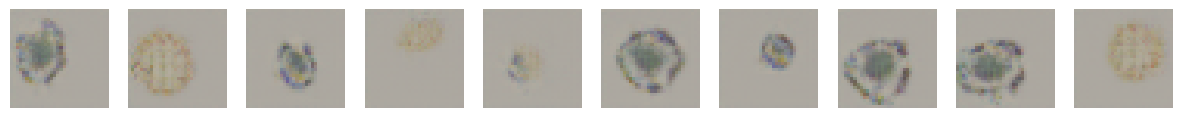

Epoch [62/150] Batch 0/313 Loss D: 0.6806609034538269, loss G: 0.706070065498352


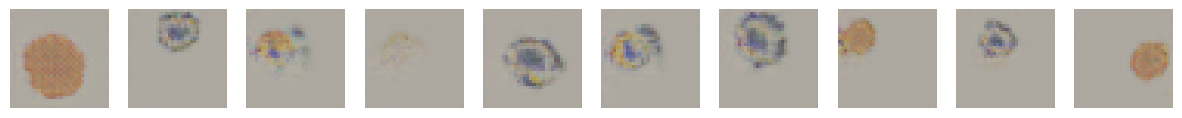

Epoch [63/150] Batch 0/313 Loss D: 0.6819246411323547, loss G: 0.7328628301620483


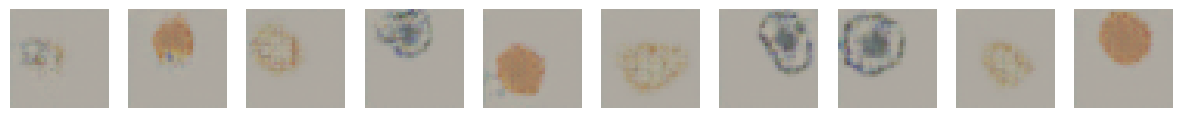

Epoch [64/150] Batch 0/313 Loss D: 0.6766608953475952, loss G: 0.7225794196128845


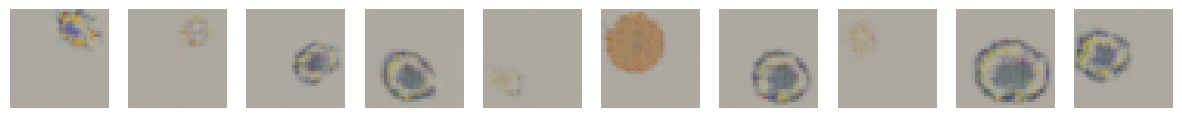

Epoch [65/150] Batch 0/313 Loss D: 0.6779842376708984, loss G: 0.7154065370559692


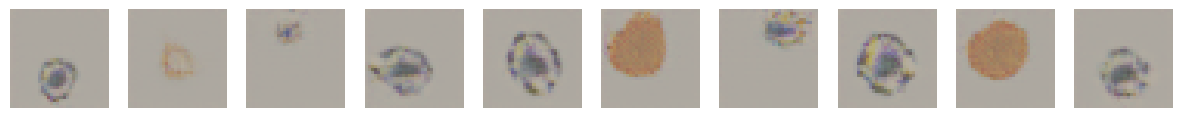

Epoch [66/150] Batch 0/313 Loss D: 0.6375753879547119, loss G: 0.6642054319381714


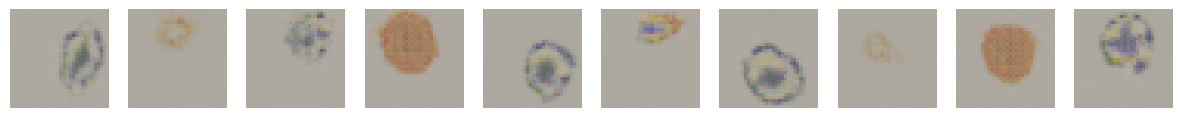

Epoch [67/150] Batch 0/313 Loss D: 0.4997844398021698, loss G: 0.8615436553955078


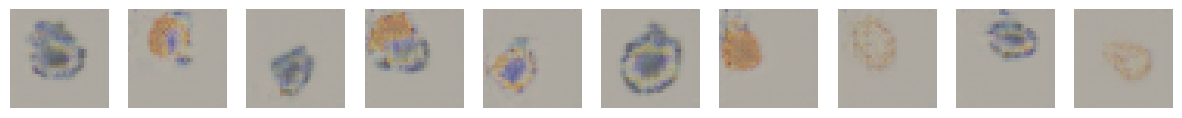

Epoch [68/150] Batch 0/313 Loss D: 0.6392514705657959, loss G: 0.8801156878471375


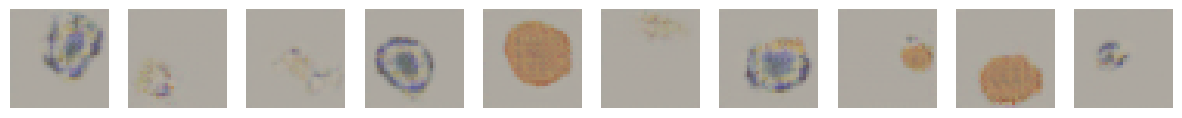

Epoch [69/150] Batch 0/313 Loss D: 0.5426992774009705, loss G: 0.7353907823562622


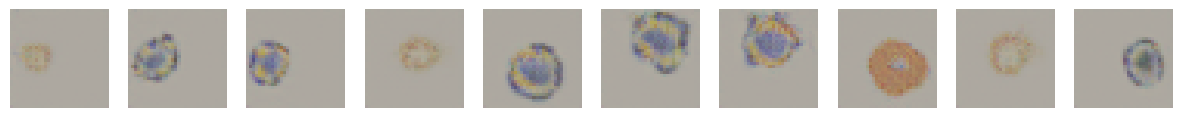

Epoch [70/150] Batch 0/313 Loss D: 0.5910327434539795, loss G: 1.1032898426055908


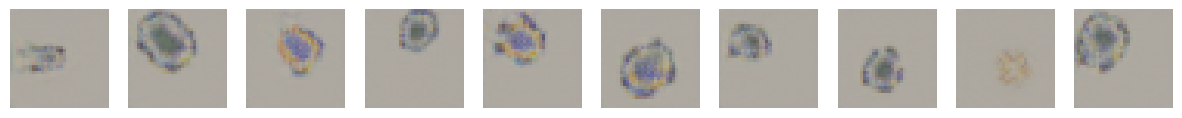

Epoch [71/150] Batch 0/313 Loss D: 0.5643949508666992, loss G: 1.1159541606903076


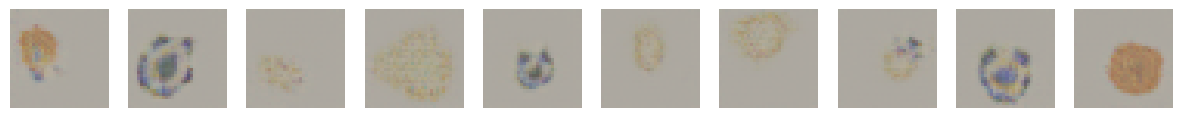

Epoch [72/150] Batch 0/313 Loss D: 0.5853886008262634, loss G: 0.747881293296814


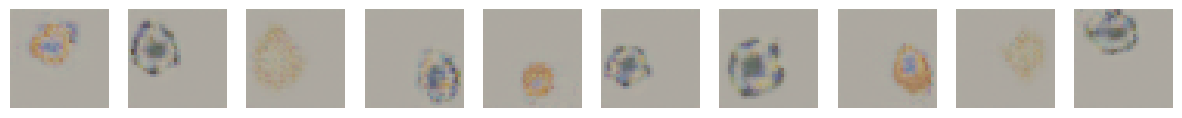

Epoch [73/150] Batch 0/313 Loss D: 0.6013715267181396, loss G: 0.7169269323348999


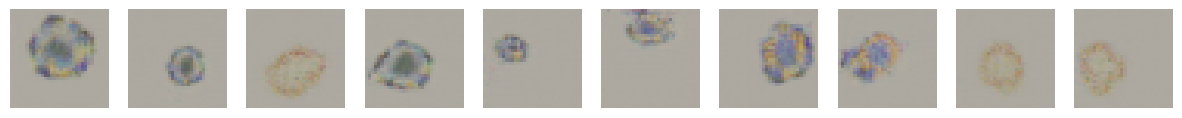

Epoch [74/150] Batch 0/313 Loss D: 0.5998737812042236, loss G: 0.9760456085205078


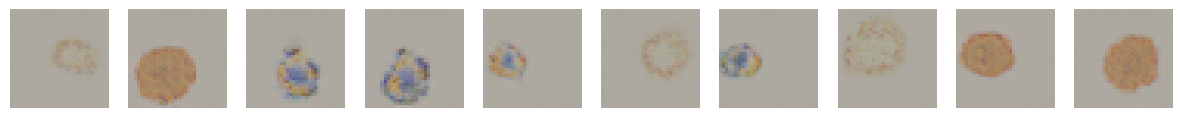

Epoch [75/150] Batch 0/313 Loss D: 0.5165427327156067, loss G: 0.8597268462181091


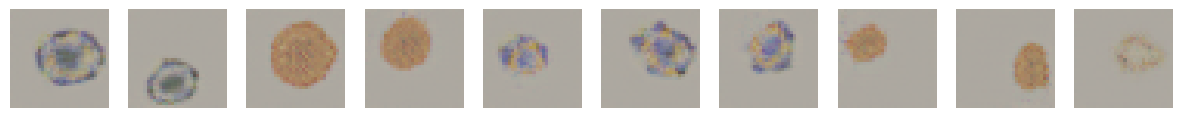

Epoch [76/150] Batch 0/313 Loss D: 0.5972330570220947, loss G: 1.0226938724517822


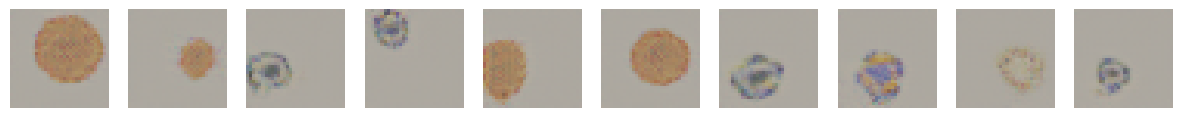

Epoch [77/150] Batch 0/313 Loss D: 0.5249773263931274, loss G: 0.7338935732841492


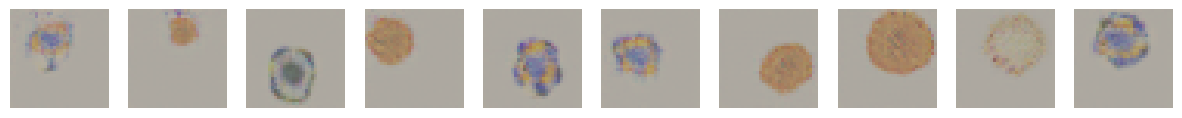

Epoch [78/150] Batch 0/313 Loss D: 0.6437160968780518, loss G: 0.6254794597625732


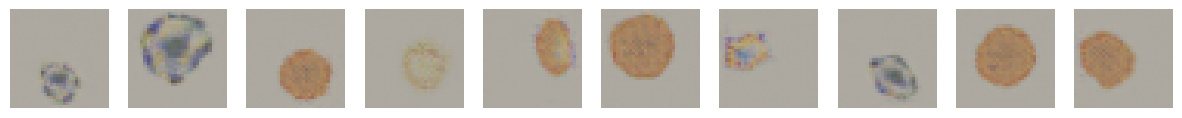

Epoch [79/150] Batch 0/313 Loss D: 0.28514307737350464, loss G: 1.7160089015960693


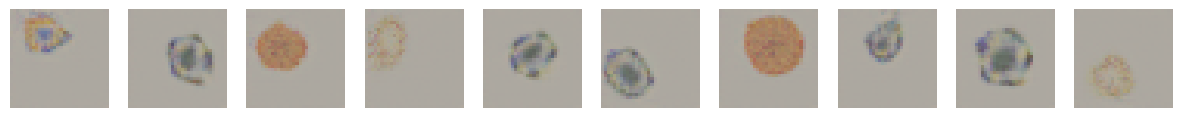

Epoch [80/150] Batch 0/313 Loss D: 0.5061092376708984, loss G: 0.8672857880592346


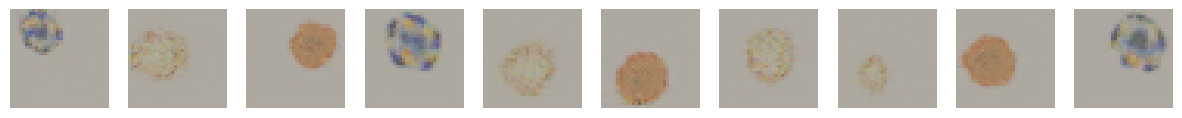

Epoch [81/150] Batch 0/313 Loss D: 0.4327623248100281, loss G: 1.7309209108352661


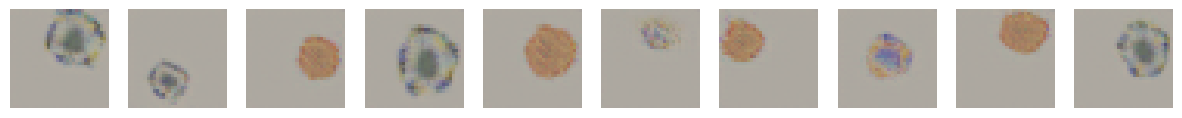

Epoch [82/150] Batch 0/313 Loss D: 0.5946898460388184, loss G: 0.6777197122573853


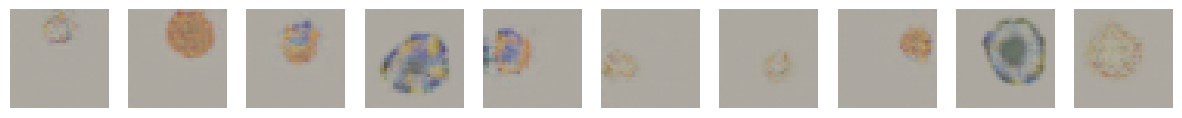

Epoch [83/150] Batch 0/313 Loss D: 0.3982425928115845, loss G: 1.3326680660247803


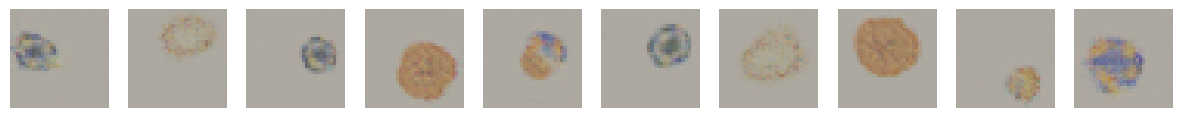

Epoch [84/150] Batch 0/313 Loss D: 0.4587632715702057, loss G: 0.7016528844833374


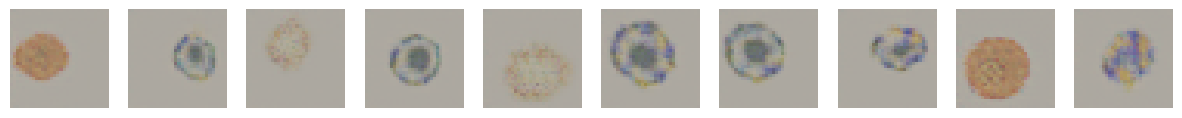

Epoch [85/150] Batch 0/313 Loss D: 0.4844587445259094, loss G: 1.1611285209655762


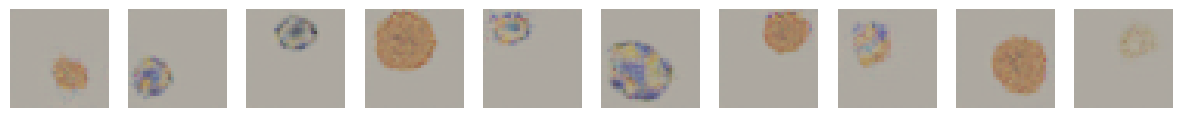

Epoch [86/150] Batch 0/313 Loss D: 0.3334488272666931, loss G: 1.7106372117996216


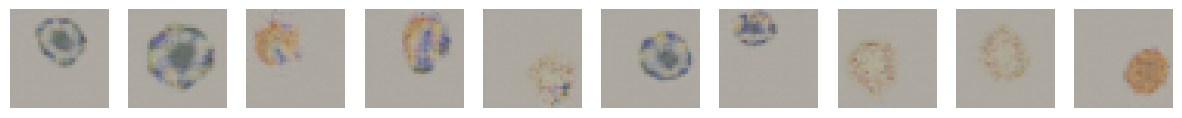

Epoch [87/150] Batch 0/313 Loss D: 0.329768568277359, loss G: 1.5477204322814941


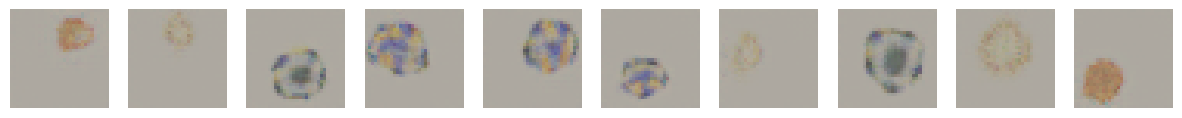

Epoch [88/150] Batch 0/313 Loss D: 0.37519460916519165, loss G: 1.2922172546386719


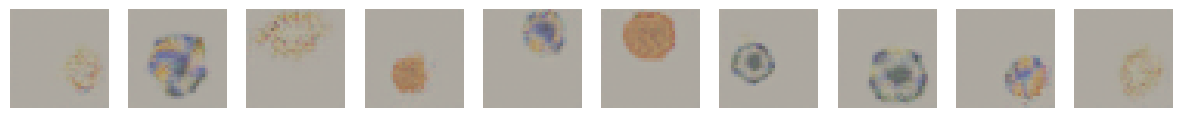

Epoch [89/150] Batch 0/313 Loss D: 0.4712052345275879, loss G: 1.3028478622436523


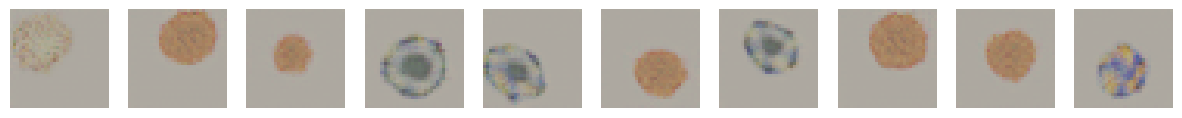

Epoch [90/150] Batch 0/313 Loss D: 0.2721007466316223, loss G: 1.7358686923980713


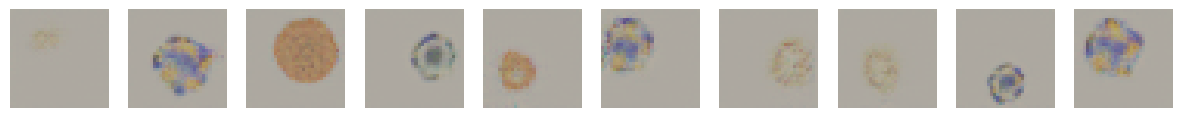

Epoch [91/150] Batch 0/313 Loss D: 0.4852478504180908, loss G: 0.780296802520752


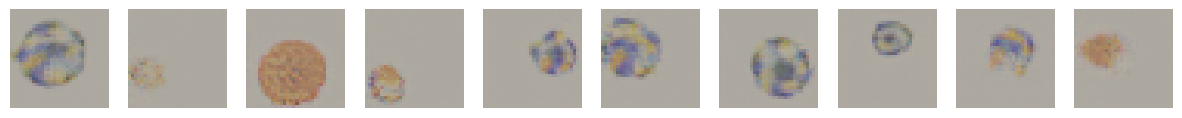

Epoch [92/150] Batch 0/313 Loss D: 0.34289222955703735, loss G: 1.1263731718063354


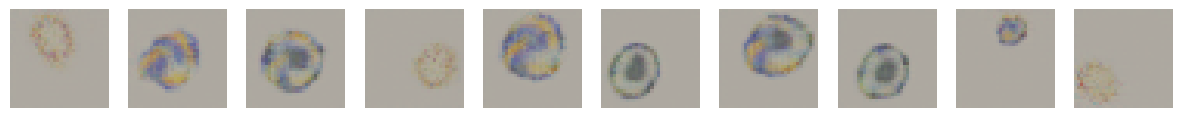

Epoch [93/150] Batch 0/313 Loss D: 0.5973954200744629, loss G: 0.5649267435073853


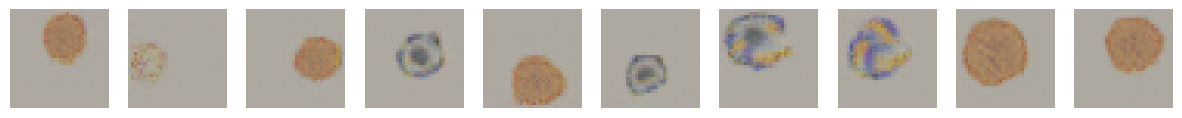

Epoch [94/150] Batch 0/313 Loss D: 0.4295804500579834, loss G: 0.9536498785018921


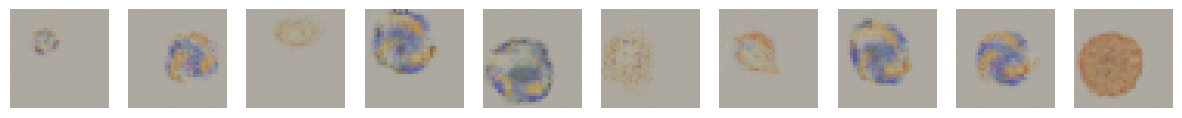

Epoch [95/150] Batch 0/313 Loss D: 0.3940277695655823, loss G: 0.8835650086402893


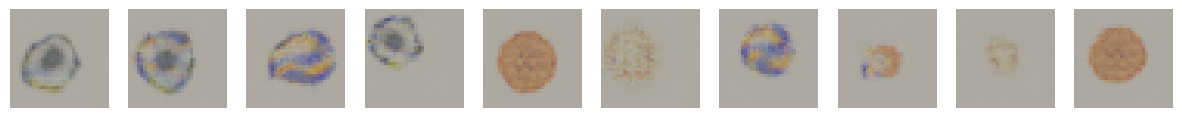

Epoch [96/150] Batch 0/313 Loss D: 0.49638402462005615, loss G: 0.6442314982414246


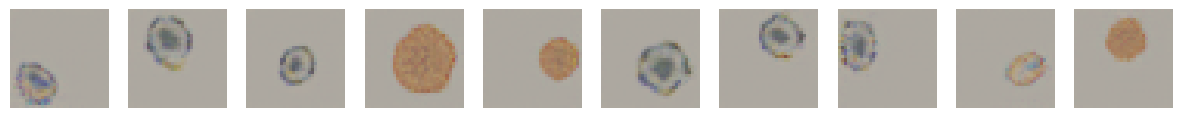

Epoch [97/150] Batch 0/313 Loss D: 0.29462116956710815, loss G: 1.4033632278442383


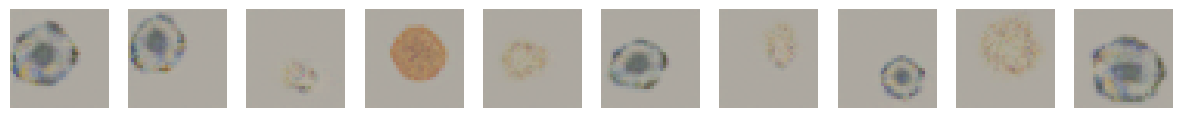

Epoch [98/150] Batch 0/313 Loss D: 0.30215734243392944, loss G: 1.0854228734970093


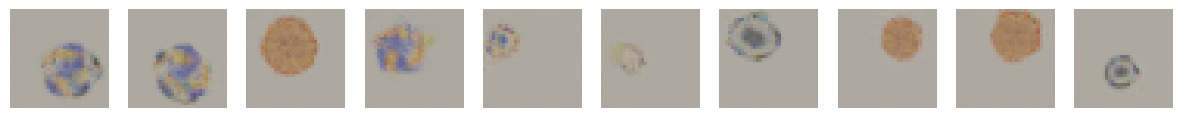

Epoch [99/150] Batch 0/313 Loss D: 0.515155553817749, loss G: 0.7748243808746338


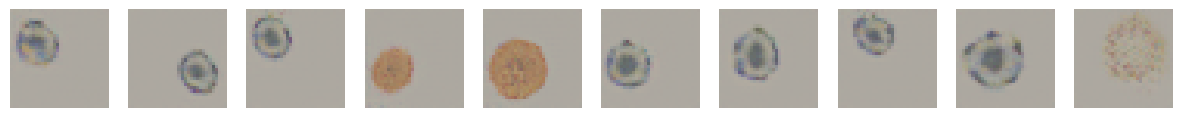

Epoch [100/150] Batch 0/313 Loss D: 0.1986486166715622, loss G: 2.519481658935547


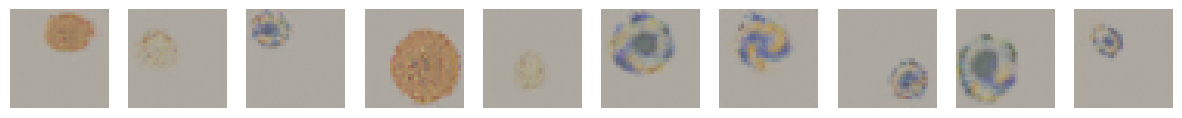

Epoch [101/150] Batch 0/313 Loss D: 0.4554450511932373, loss G: 0.6882604360580444


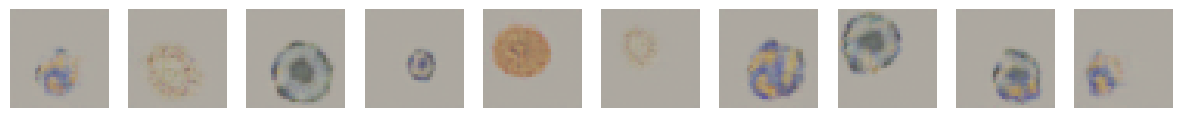

Epoch [102/150] Batch 0/313 Loss D: 0.3533012866973877, loss G: 1.0899436473846436


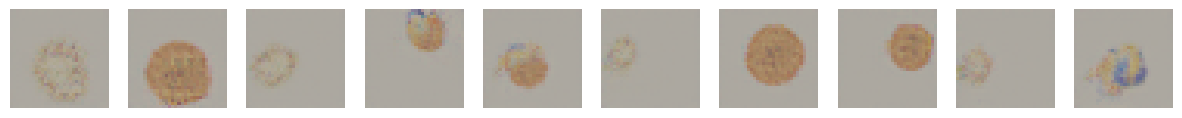

Epoch [103/150] Batch 0/313 Loss D: 0.3354756236076355, loss G: 0.9746906161308289


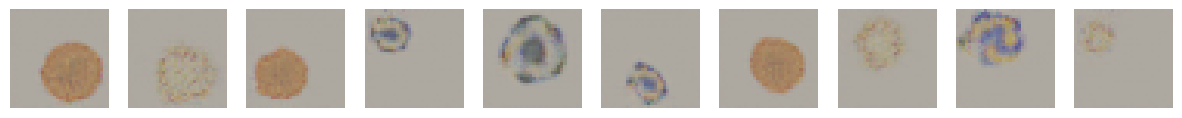

Epoch [104/150] Batch 0/313 Loss D: 0.38299280405044556, loss G: 1.1821508407592773


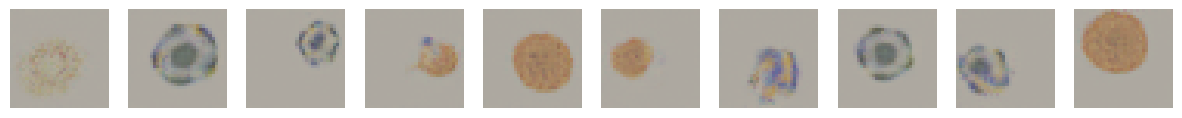

Epoch [105/150] Batch 0/313 Loss D: 0.3400111198425293, loss G: 1.205674171447754


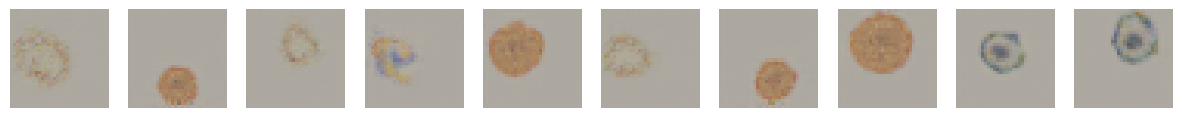

Epoch [106/150] Batch 0/313 Loss D: 0.2312040627002716, loss G: 1.8003413677215576


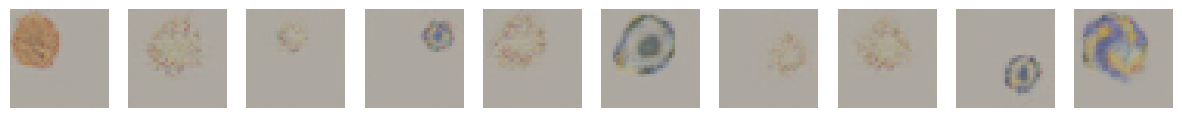

Epoch [107/150] Batch 0/313 Loss D: 0.4167725443840027, loss G: 2.4816436767578125


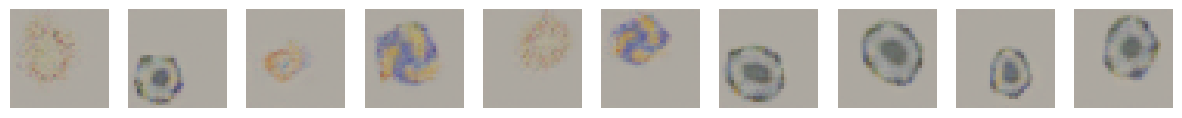

Epoch [108/150] Batch 0/313 Loss D: 0.5012410283088684, loss G: 0.5749329328536987


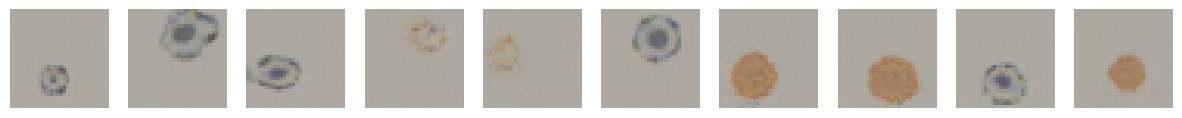

Epoch [109/150] Batch 0/313 Loss D: 0.2075732797384262, loss G: 1.321471095085144


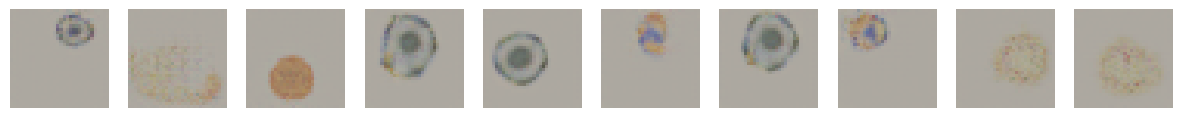

Epoch [110/150] Batch 0/313 Loss D: 0.2036079466342926, loss G: 2.4208321571350098


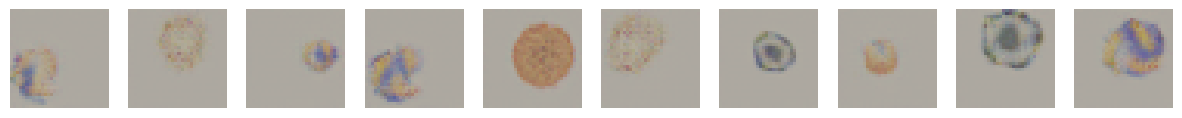

Epoch [111/150] Batch 0/313 Loss D: 0.3544178009033203, loss G: 2.2244653701782227


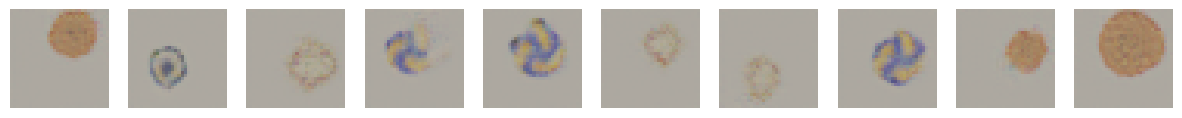

Epoch [112/150] Batch 0/313 Loss D: 0.3757280111312866, loss G: 1.3461921215057373


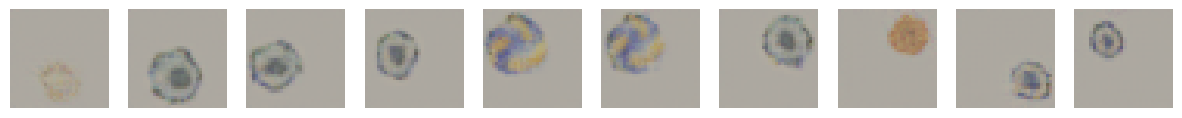

Epoch [113/150] Batch 0/313 Loss D: 0.17946036159992218, loss G: 1.9249274730682373


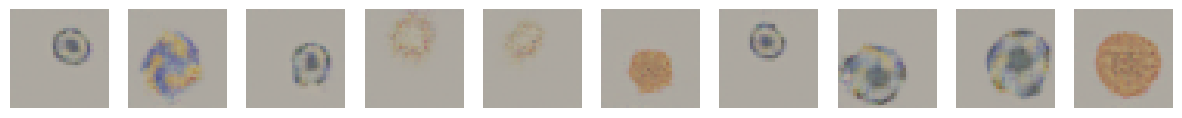

Epoch [114/150] Batch 0/313 Loss D: 0.1579875349998474, loss G: 3.287200927734375


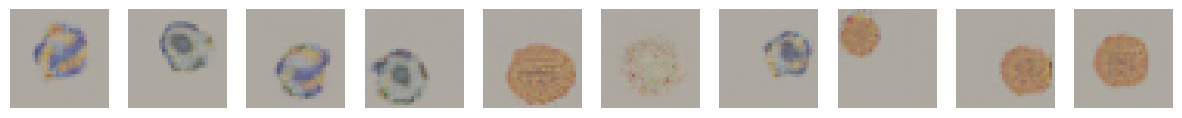

Epoch [115/150] Batch 0/313 Loss D: 0.2565097510814667, loss G: 2.3222904205322266


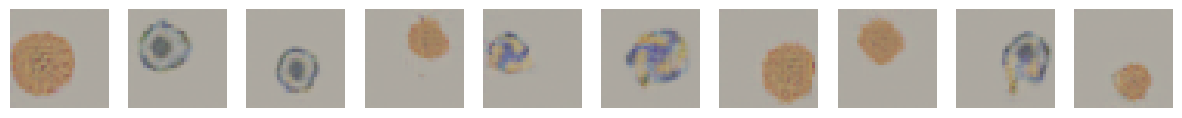

Epoch [116/150] Batch 0/313 Loss D: 0.5347868204116821, loss G: 0.5723736882209778


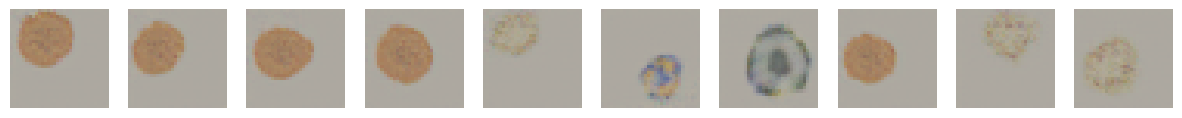

Epoch [117/150] Batch 0/313 Loss D: 0.37256911396980286, loss G: 0.7389276027679443


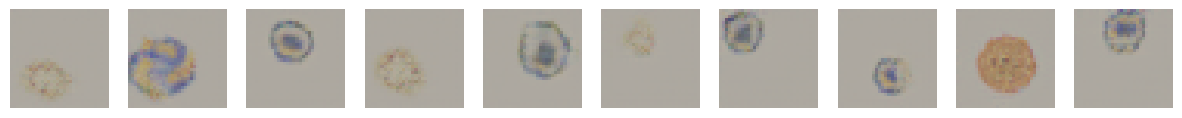

Epoch [118/150] Batch 0/313 Loss D: 0.6903512477874756, loss G: 2.492151975631714


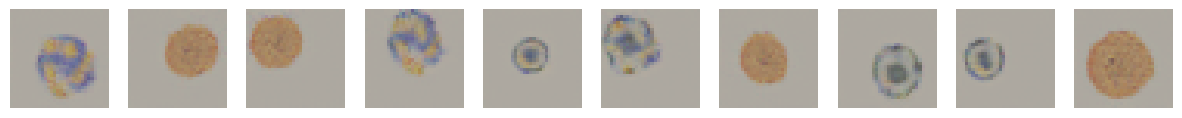

Epoch [119/150] Batch 0/313 Loss D: 0.15984930098056793, loss G: 1.6845101118087769


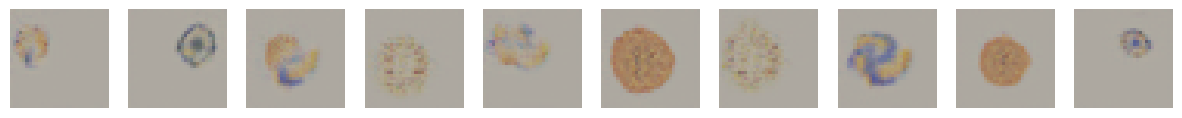

Epoch [120/150] Batch 0/313 Loss D: 0.45638060569763184, loss G: 1.911844253540039


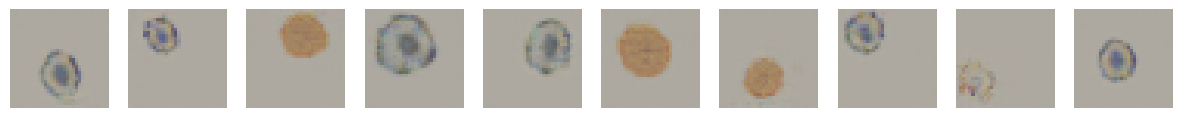

Epoch [121/150] Batch 0/313 Loss D: 0.21280093491077423, loss G: 2.418576240539551


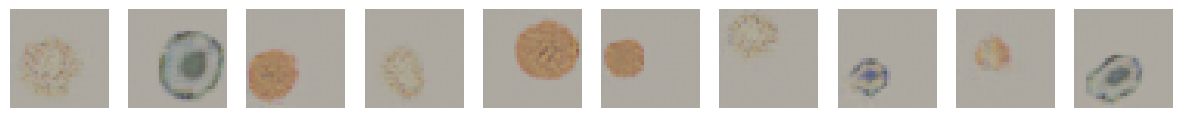

Epoch [122/150] Batch 0/313 Loss D: 0.24407687783241272, loss G: 1.4229353666305542


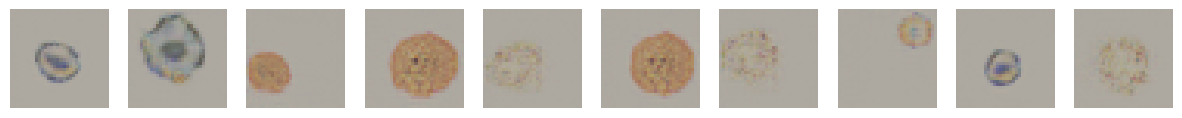

Epoch [123/150] Batch 0/313 Loss D: 0.2260582447052002, loss G: 2.8985161781311035


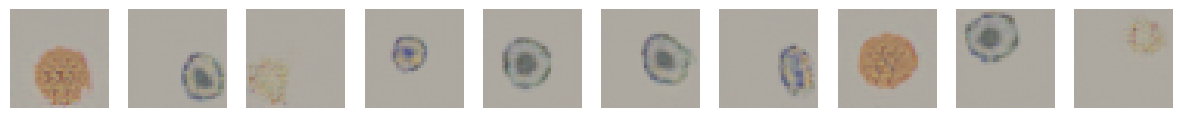

Epoch [124/150] Batch 0/313 Loss D: 0.12586094439029694, loss G: 2.201137065887451


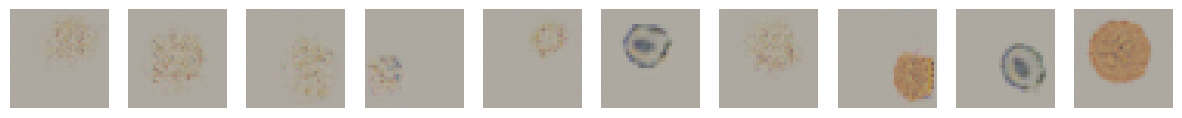

Epoch [125/150] Batch 0/313 Loss D: 0.1106327474117279, loss G: 1.8491687774658203


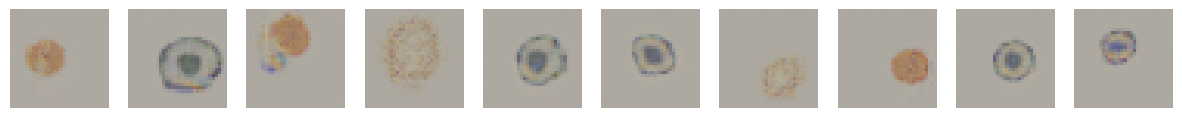

Epoch [126/150] Batch 0/313 Loss D: 0.3208434581756592, loss G: 2.2572288513183594


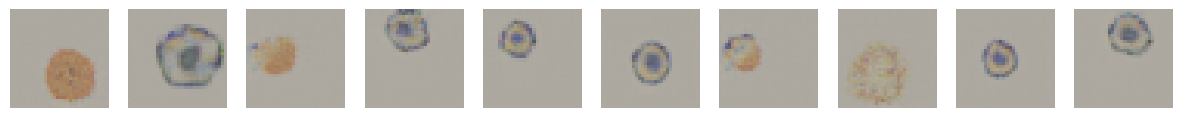

Epoch [127/150] Batch 0/313 Loss D: 0.37444549798965454, loss G: 0.9618628621101379


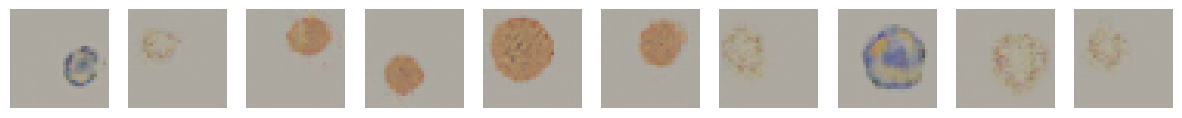

Epoch [128/150] Batch 0/313 Loss D: 0.2259819656610489, loss G: 2.7548561096191406


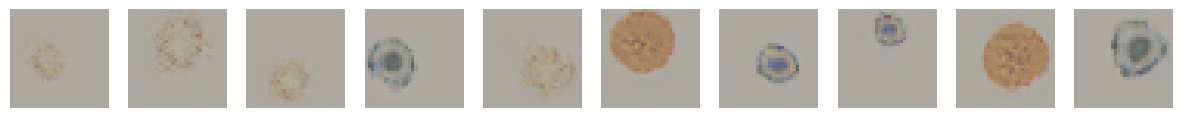

Epoch [129/150] Batch 0/313 Loss D: 0.16708944737911224, loss G: 1.7697460651397705


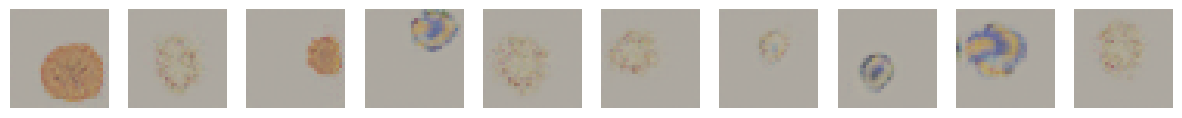

Epoch [130/150] Batch 0/313 Loss D: 0.2563096582889557, loss G: 2.5131330490112305


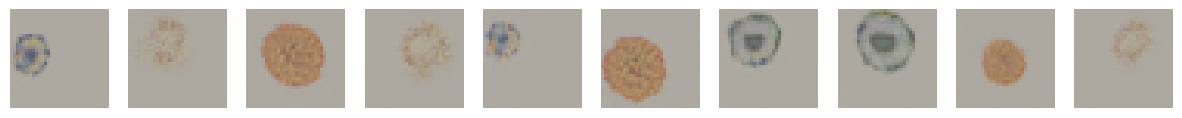

Epoch [131/150] Batch 0/313 Loss D: 0.1158546656370163, loss G: 4.1192626953125


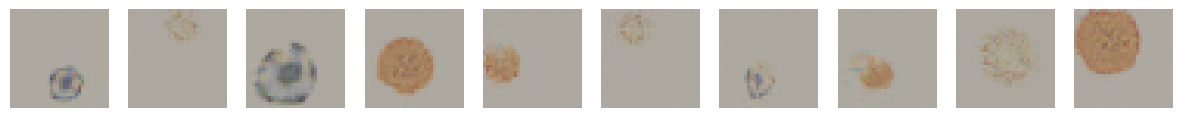

Epoch [132/150] Batch 0/313 Loss D: 0.23338629305362701, loss G: 1.1155226230621338


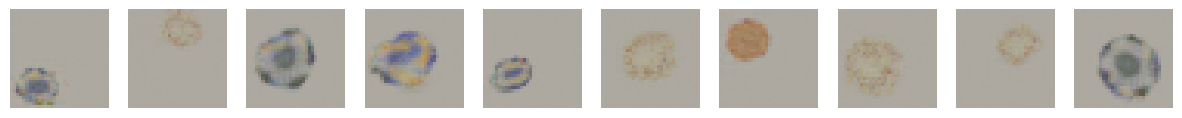

Epoch [133/150] Batch 0/313 Loss D: 0.024694904685020447, loss G: 3.8043060302734375


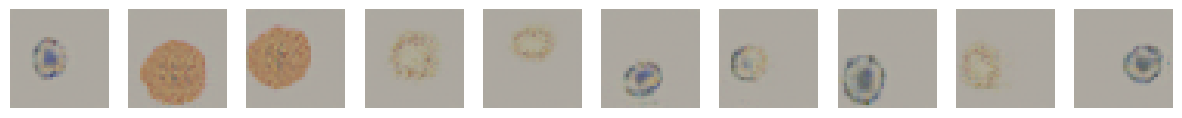

Epoch [134/150] Batch 0/313 Loss D: 0.21016952395439148, loss G: 4.343022346496582


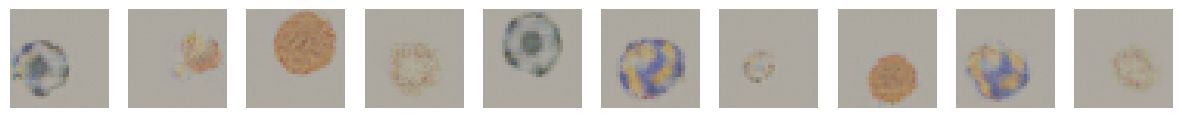

Epoch [135/150] Batch 0/313 Loss D: 0.20588792860507965, loss G: 1.374971628189087


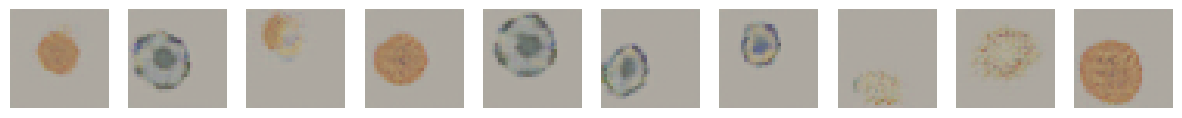

Epoch [136/150] Batch 0/313 Loss D: 0.2835945188999176, loss G: 1.0931049585342407


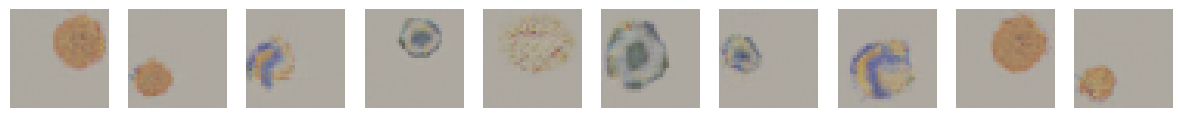

Epoch [137/150] Batch 0/313 Loss D: 0.139320969581604, loss G: 2.7535667419433594


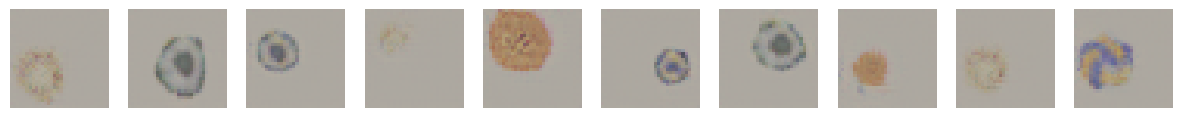

Epoch [138/150] Batch 0/313 Loss D: 0.338765949010849, loss G: 2.9519524574279785


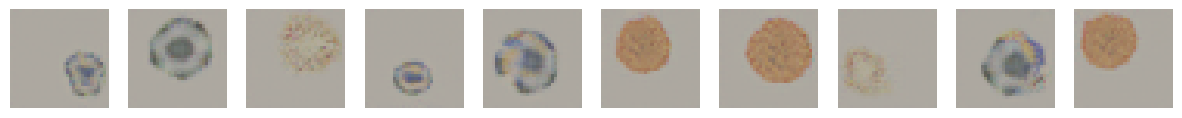

Epoch [139/150] Batch 0/313 Loss D: 0.2695079743862152, loss G: 1.1448265314102173


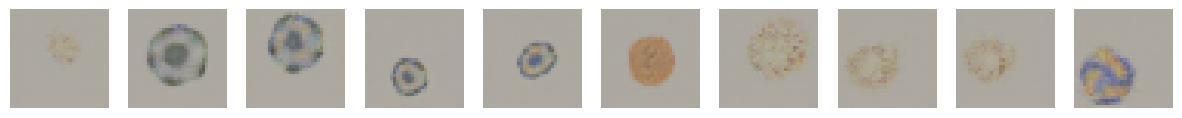

Epoch [140/150] Batch 0/313 Loss D: 0.21962952613830566, loss G: 2.8232269287109375


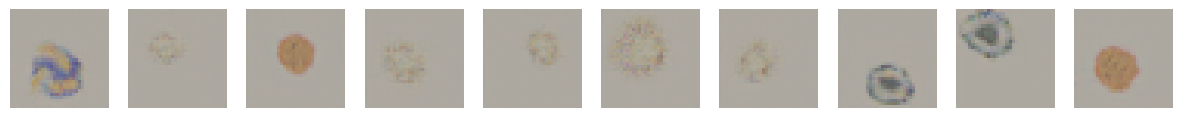

Epoch [141/150] Batch 0/313 Loss D: 0.1436215490102768, loss G: 3.2496345043182373


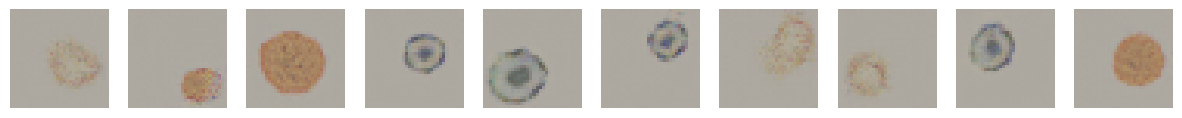

Epoch [142/150] Batch 0/313 Loss D: 0.6578841209411621, loss G: 0.37704312801361084


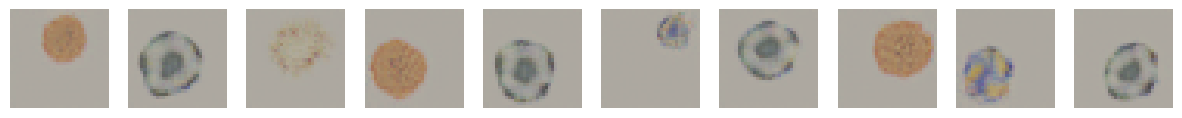

Epoch [143/150] Batch 0/313 Loss D: 0.06160271167755127, loss G: 2.9311838150024414


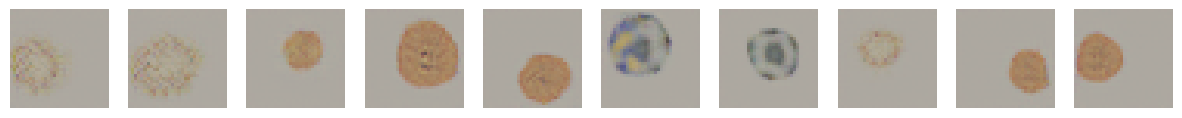

Epoch [144/150] Batch 0/313 Loss D: 0.20275135338306427, loss G: 3.116076707839966


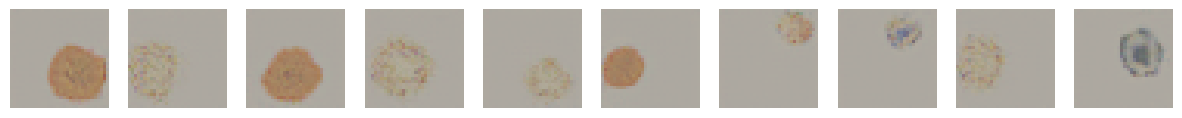

Epoch [145/150] Batch 0/313 Loss D: 0.13708752393722534, loss G: 3.3873538970947266


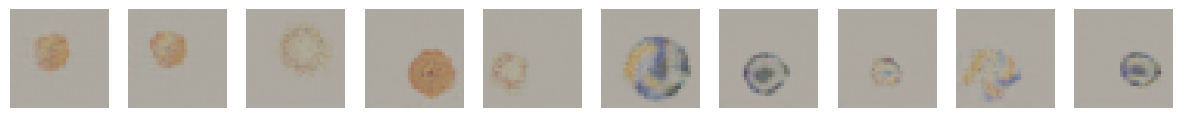

Epoch [146/150] Batch 0/313 Loss D: 0.1576937437057495, loss G: 1.8772377967834473


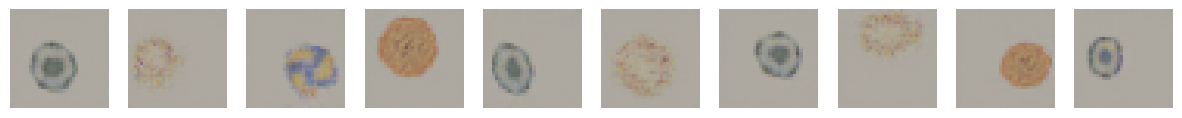

Epoch [147/150] Batch 0/313 Loss D: 0.08993428945541382, loss G: 3.204312324523926


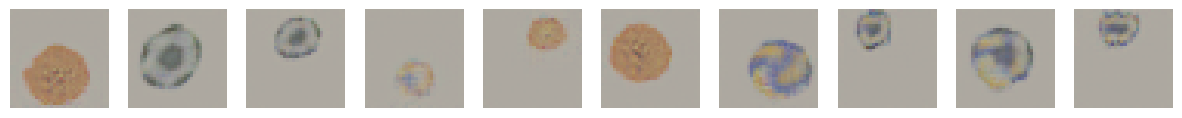

Epoch [148/150] Batch 0/313 Loss D: 0.10559401661157608, loss G: 3.1299562454223633


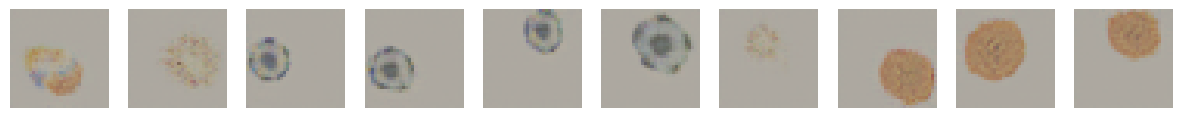

Epoch [149/150] Batch 0/313 Loss D: 0.2804844081401825, loss G: 5.175076484680176


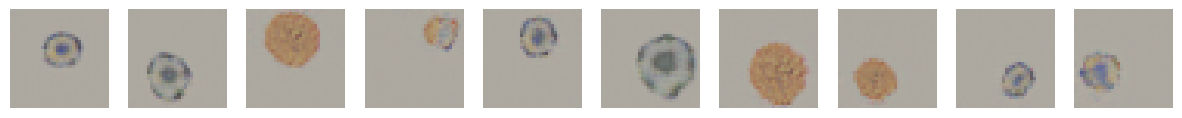

In [237]:
g_losses, d_losses, generator, discriminator =  train(generator, discriminator, train_loader, epochs, latent_dim, learning_rate, loss)

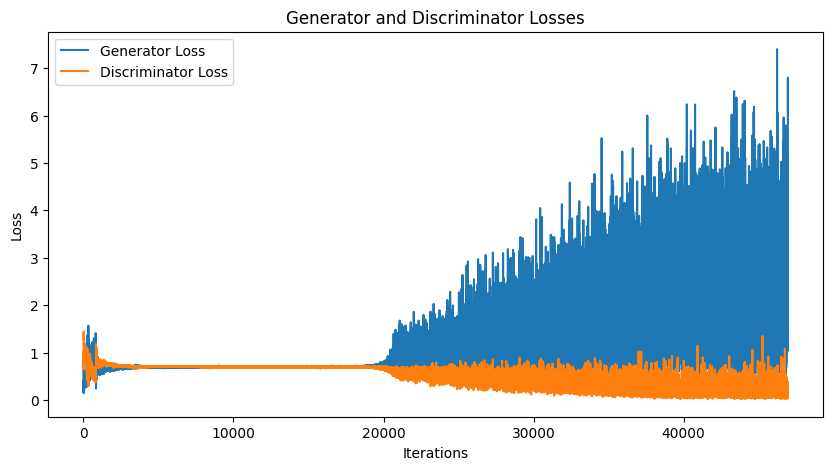

In [238]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Losses')
plt.show()

In [102]:
torch.save(generator.state_dict(), 'generator_v1_GAN.pth')
torch.save(discriminator.state_dict(), 'discriminator_v1_GAN.pth')

Let's check if the model was successfully saved:

In [7]:
# We should first define the model structure
generator = Generator(256)

# Load the model
generator.load_state_dict(torch.load('generator_v1_GAN.pth'))

<All keys matched successfully>

Now let's try to generate some images from random vector:

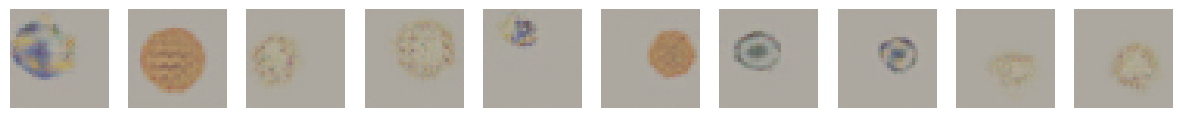

In [22]:
noise = torch.randn(100, 256).to(device)
generator = generator.to(device)
generated_images = generator(noise)
generated_images = denormalize(generated_images)
generated_images = generated_images.cpu().detach().numpy().transpose(0, 2, 3, 1)

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for img, ax in zip(generated_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.show()

<p style="background-color: white; color: black; margin-left: 40%; margin-right: 40%; font-family: Cambria; font-size: 2em; text-align: center; border-radius: 0px; padding: 5px; border: 0px solid black;">
Created by:
</p>
<p style="background-color: white; color: black; font-family: Garamond; font-size: 2em; text-align: left; border-radius: 15px; padding: 25px; box-shadow: 0 4px 8px lightsteelblue; border: 1px solid black;">
Novotochin Artem
    <br>
    <br>
    <br>
Data scientist || Data analyst
</p>